In [42]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydotplus # viz stuff

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree # export_graphviz() method

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from IPython.display import Image # viz stuff

In [43]:
df = pd.read_csv("data/data_understanding_output.csv", skipinitialspace=True)
df_train = df.drop(['word','PoS', 'length', 'number_of_meanings', 'avg_variance_between_meanings', 'polysemy'], axis=1)

In [44]:
df_train.head()

,arousal,valence,dominance,concreteness,imageability,familiarity,aoa,semsize,gender,log_freq,sentiment
0,4.200,2.864,4.333,5.455,4.391,2.382,6.760,4.652,5.391,5.204321,1.0
1,3.125,5.781,4.667,5.906,5.344,3.324,5.177,5.121,3.303,6.625813,1.0
2,3.273,5.250,5.235,3.286,3.177,5.121,5.543,2.667,3.971,5.146454,1.0
3,4.194,3.767,4.419,3.367,2.516,3.971,6.233,4.679,5.167,5.093852,1.0
4,3.846,3.880,4.800,3.292,2.571,3.097,6.407,5.083,4.571,5.107695,1.0


In [45]:
attributes = [col for col in df_train.columns if col != 'sentiment']
X = df_train[attributes].values
y = df_train['sentiment']

In [58]:
# Questo blocco ci mette un botto ad eseguire e serve solo a trovare i parametri migliori

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

twotwenty = list(range(2,20))
    
param_list = {'max_depth': [None] + twotwenty,
             'min_samples_split': twotwenty,
             'min_samples_leaf': list(range(1,20))
             }

grid_search = GridSearchCV(clf, param_grid=param_list, scoring='f1_weighted')
grid_search.fit(X, y)

res = grid_search.cv_results_

report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.877 (std: 0.014)
Parameters: {'max_depth': 6, 'min_samples_leaf': 17, 'min_samples_split': 13}

Model with rank: 2
Mean validation score: 0.877 (std: 0.012)
Parameters: {'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 12}

Model with rank: 2
Mean validation score: 0.877 (std: 0.012)
Parameters: {'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 17}



In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [59]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=7 ,
                             min_samples_split=15,
                             min_samples_leaf=12,
                            )

clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=12, min_samples_split=15)

In [60]:
imp_dict = {attr: clf.feature_importances_[i] for i, attr in enumerate(attributes)}
{k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1], reverse=True)}

{'valence': 0.6182438854956706,
 'concreteness': 0.1441789275223601,
 'familiarity': 0.08038517955813321,
 'arousal': 0.051049834871479724,
 'imageability': 0.025612136095645513,
 'dominance': 0.02078386042342292,
 'aoa': 0.02033255418555386,
 'semsize': 0.019660846151961925,
 'log_freq': 0.014906881128310817,
 'gender': 0.004845894567461482}

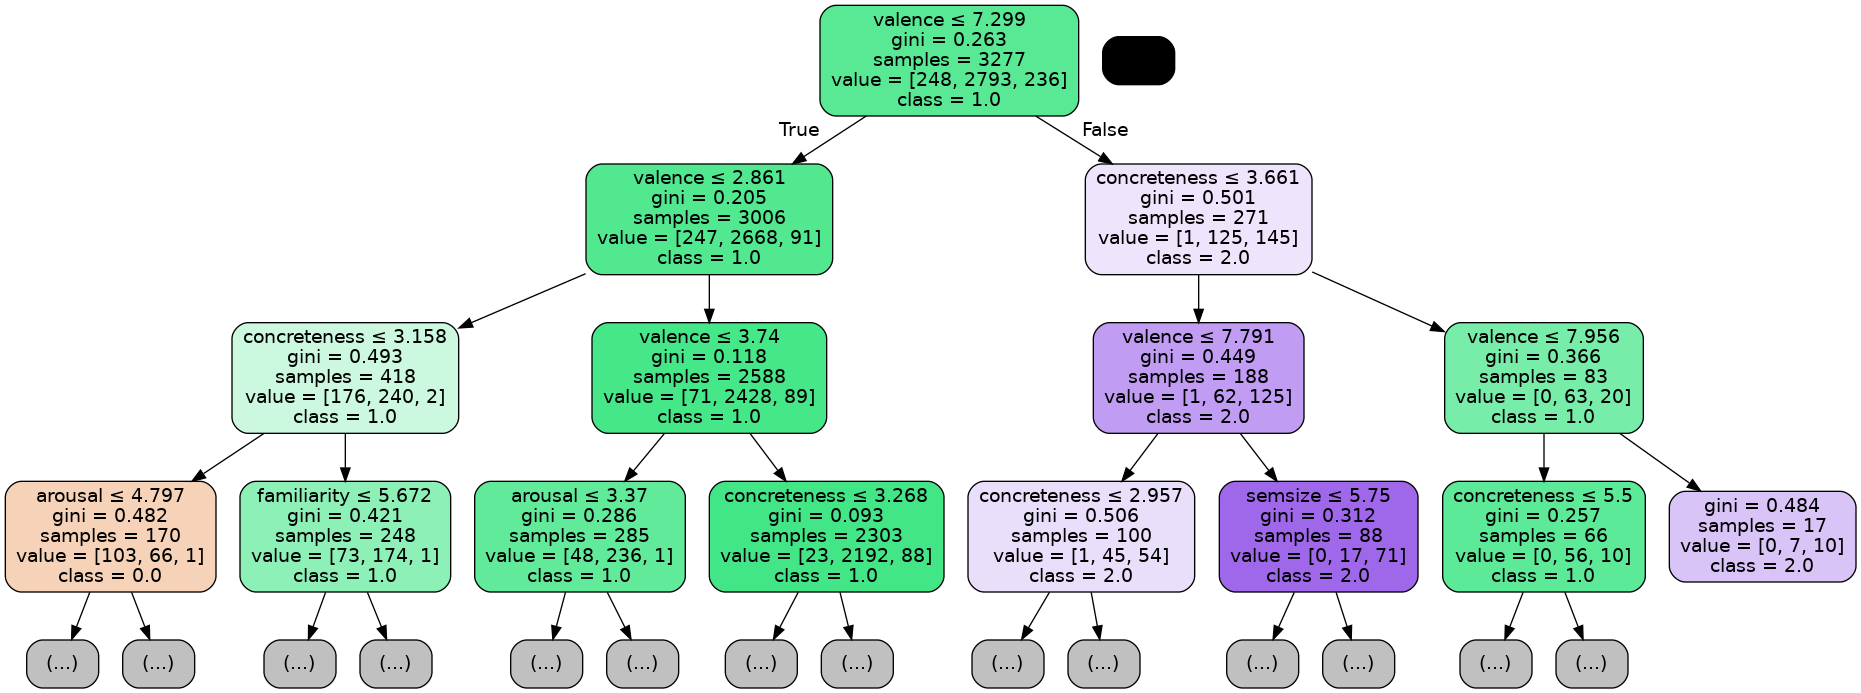

In [61]:
dot_data = tree.export_graphviz (clf, out_file=None,
                                feature_names=attributes,
                                class_names=[str(v) for v in clf.classes_],
                                filled=True, rounded=True,
                                special_characters=True,
                                max_depth=3)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [62]:
y_pred = clf.predict(X_train)

In [63]:
print( classification_report(y_train, y_pred) )

              precision    recall  f1-score   support

         0.0       0.78      0.55      0.64       248
         1.0       0.93      0.97      0.95      2793
         2.0       0.78      0.56      0.65       236

    accuracy                           0.91      3277
   macro avg       0.83      0.69      0.75      3277
weighted avg       0.91      0.91      0.90      3277



In [64]:
y_pred = clf.predict(X_test)

In [65]:
print( classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

         0.0       0.58      0.42      0.49       106
         1.0       0.91      0.95      0.93      1198
         2.0       0.68      0.55      0.61       101

    accuracy                           0.88      1405
   macro avg       0.72      0.64      0.68      1405
weighted avg       0.87      0.88      0.88      1405

